# Use Case 3: Airline Sentiment Analysis
## Author : Pratik Shirbhate
## Date: 20-08-2020
### Description of use case:
This use case is about predicting the sentiment of the tweet as negative, neutral or positive
Note: This notebook is still in development, comments are incomplete, for evaluation you can use 'Use Case 1'

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Make sure to have all the data file in the working folder
df = pd.read_csv("Usecase3_Dataset.csv")

In [3]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [4]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [5]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [6]:
df['text'].isna().sum()

0

In [7]:
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

In [8]:
def clean_text(text):
    """
    """
    # lower the case
    text = text.lower()
    # Remove the airline mention
    text = ' '.join(word for word in text.split(' ') if not word.startswith('@'))
    # Remove the punctuations
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    word_tokens = word_tokenize(text) 
    filtered_sentence = [stemmer.stem(w) for w in word_tokens if not w in stop_words]
    text = ' '.join(filtered_sentence)
    return text

In [9]:
df['processed_text'] = df['text'].apply(clean_text)

In [10]:
df.head()

,airline_sentiment,airline,text,processed_text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,said
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,plus ad commerci experi tacki
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,today must mean need take anoth trip
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain guest fa...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,realli big bad thing


In [11]:
# Encode the labels
le = LabelEncoder()
df["airline_sentiment_label"] = le.fit_transform(df['airline_sentiment'])
# Display the encoded labels
display(df[["airline_sentiment", "airline_sentiment_label"]].head())

,airline_sentiment,airline_sentiment_label
0,neutral,1
1,positive,2
2,neutral,1
3,negative,0
4,negative,0


In [12]:
# Select the features and the target
X = df['processed_text']
y = df["airline_sentiment_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [16]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)
# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

In [17]:
# Create a DataFrame for tf-idf vectors and display the first rows
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

,00,000,0016,00am,00pm,02,03,05,05am,05pm,...,yuma,yup,yvonn,yvr,ywg,yyz,zero,zik2uoxgnw,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
nb = BernoulliNB()
# Fit the model
nb.fit(tfidf_train, y_train)
# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.6757679180887372


In [20]:
y_pred = nb.predict(tfidf_test)

In [21]:
cm = confusion_matrix(y_test, y_pred)

In [22]:
cm

array([[1641,  139,   56],
       [ 241,  329,   50],
       [ 112,   65,  295]], dtype=int64)

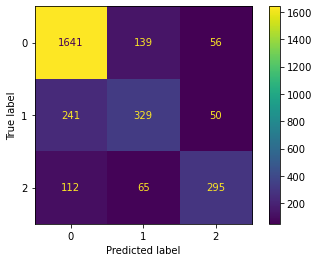

In [24]:
plot_confusion_matrix(nb, tfidf_test, y_test)
plt.show()